<a href="https://colab.research.google.com/github/GuysBarash/Genetic-programing-with-DEAP/blob/master/evolutionarty_GP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!apt install libgraphviz-dev
!pip install pygraphviz
import pygraphviz as pgv

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgraphviz-dev is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 43 not upgraded.


In [19]:
!pip install DEAP

In [0]:
import random
import operator
import os
import numpy as np
import pandas as pd

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp
from datetime import datetime
from deap.tools import History

from IPython.display import display
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, recall_score, precision_score, fbeta_score
from sklearn import preprocessing

# Generate Data

In [0]:
import sys
colab_mode = 'google.colab' in sys.modules

In [22]:
if not colab_mode:
  train_set = r"C:\school\evolutionary\ex2\validate.csv" # This is where the file is kept
  rawdatadf = pd.read_csv(train_set, header=None)
else:
  from google.colab import drive

  drive.mount('/content/drive')
  base_folder = r'/content/drive/My Drive/colab_storage'
  rawdatadf = pd.read_csv(os.path.join(base_folder ,'validate.csv'))



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
datacols = rawdatadf.columns[1:]

def get_last_n_tuples_from_cols(n, cols):
    return cols[-4 * n:]


datacols = get_last_n_tuples_from_cols(7, rawdatadf.columns[1:])
datadf = pd.DataFrame(columns=datacols,
                      index=range(rawdatadf.shape[0]),
                      data=rawdatadf[datacols])

datadf -= datadf.mean(axis=0)
datadf /= datadf.std(axis=0)
datadf -= datadf.min()
datadf /= datadf.max()

labels = rawdatadf[rawdatadf.columns[0]]
labelcol = 'LABEL'
datadf[labelcol] = labels

In [25]:
top_n = 14
display(datadf.head(14))
print("")
print(f"Displaying top {top_n} out of {len(datadf)}")

,2591,99.91659546,1019,99.93080139,1916,99.93747711,1410,99.95471191,2091,99.92208099,1686,99.9335022,1269,99.90940857,1234,99.92716217,1478,99.85186005,1320,99.8731308,1638,99.84020233,1553,99.86087799,1237,99.85380554,993,99.87451172,LABEL
0,0.004220,0.628274,0.007949,0.599776,0.010585,0.596142,0.014406,0.581262,0.006219,0.597563,0.008037,0.576733,0.008698,0.609693,0.009982,0.593964,0.005121,0.598614,0.004668,0.580906,0.000261,0.596905,0.000468,0.573823,0.001105,0.608873,0.001472,0.588921,0
1,0.011482,0.645930,0.012628,0.621161,0.007143,0.614934,0.009958,0.602291,0.008154,0.612502,0.008754,0.593206,0.008293,0.617246,0.009847,0.599885,0.009057,0.607803,0.005608,0.588949,0.005892,0.609883,0.006980,0.588932,0.008213,0.626191,0.002613,0.605746,1
2,0.002581,0.649873,0.001489,0.621482,0.002028,0.629802,0.004085,0.613567,0.000840,0.632337,0.001668,0.613404,0.001274,0.643437,0.001214,0.626829,0.004592,0.629787,0.005948,0.611508,0.004146,0.623209,0.005357,0.600757,0.001791,0.638659,0.000555,0.618912,0
3,0.000111,0.701385,0.000163,0.681451,0.000039,0.680405,0.000103,0.673476,0.000061,0.680753,0.000139,0.670569,0.000109,0.696069,0.000064,0.684205,0.000031,0.679926,0.000042,0.665804,0.000057,0.665322,0.000022,0.651198,0.000139,0.681413,0.000057,0.671362,0
4,0.000180,0.650104,0.000195,0.625779,0.000277,0.643586,0.001489,0.629439,0.000259,0.643486,0.000563,0.629964,0.000259,0.646487,0.000121,0.633237,0.000481,0.635416,0.000482,0.620367,0.000502,0.638020,0.000476,0.619303,0.000307,0.662899,0.000149,0.651693,1
5,0.004882,0.690314,0.008545,0.660655,0.002408,0.664250,0.003993,0.647100,0.002020,0.665354,0.005416,0.644500,0.004628,0.670551,0.005775,0.652294,0.004928,0.656236,0.006251,0.636412,0.006775,0.646178,0.013245,0.624746,0.003383,0.655179,0.001855,0.635359,0
6,0.003599,0.722501,0.002481,0.696741,0.001453,0.702960,0.002493,0.688992,0.000789,0.703052,0.001415,0.685382,0.000552,0.706462,0.000501,0.690192,0.002388,0.694596,0.003269,0.678005,0.002071,0.693142,0.003096,0.674832,0.001658,0.704399,0.001132,0.687794,0
7,0.002296,0.711087,0.002475,0.682075,0.002397,0.690867,0.003529,0.674978,0.002026,0.688014,0.003497,0.668089,0.003153,0.694357,0.002936,0.676986,0.001906,0.686332,0.001825,0.669134,0.004154,0.688158,0.005380,0.668143,0.002344,0.699890,0.001408,0.681663,1
8,0.001525,0.716709,0.001328,0.690705,0.001876,0.698337,0.002831,0.685519,0.000739,0.701809,0.002206,0.682068,0.001085,0.705813,0.001293,0.690235,0.001302,0.687425,0.003678,0.668889,0.000821,0.683666,0.002639,0.665835,0.000514,0.702663,0.000924,0.686915,0
9,0.008598,0.641817,0.004704,0.612891,0.003427,0.614281,0.007358,0.597640,0.004339,0.620105,0.002347,0.603144,0.005100,0.631644,0.003235,0.614521,0.006535,0.611885,0.021978,0.593488,0.019854,0.598805,0.026812,0.576988,0.003660,0.616244,0.006320,0.599232,1



Displaying top 14 out of 49999


Check with SVM as baseline

In [26]:
# Solve with SVM
from sklearn import svm

print("Calculating SVM")
clf = svm.LinearSVC()
clf.fit(datadf[datacols], datadf[labelcol])
predictions = clf.predict(datadf[datacols])
true_results = datadf[labelcol]
scoring_sr = pd.DataFrame(dtype=np.float, columns=['value'])
scoring_sr.loc['Accuracy', 'value'] = accuracy_score(true_results, predictions)
scoring_sr.loc['Recall', 'value'] = recall_score(true_results, predictions)
scoring_sr.loc['precision', 'value'] = precision_score(true_results, predictions)
scoring_sr.loc['F0.25', 'value'] = fbeta_score(true_results, predictions, beta=0.25)

display(scoring_sr)
print("DONE WITH SVM")

Calculating SVM


,value
Accuracy,0.520170
Recall,0.672993
precision,0.515865
F0.25,0.523049


DONE WITH SVM


# Defining evolution parameters

register operands

In [0]:
def activation(a):
    return np.tanh(a)


def neg(a):
    return -a


def double(a):
    return 2.0 * a


def half(a):
    return 0.5 * a

In [0]:
pset = gp.PrimitiveSet("MAIN", 5, "IN")
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(np.square, 1)
pset.addPrimitive(neg, 1)
pset.addPrimitive(double, 1)
pset.addPrimitive(half, 1)
pset.addPrimitive(activation, 1)
pset.addTerminal(np.float64(1.0))
pset.addTerminal(np.float64(0.5))
pset.addTerminal(np.float64(2.0))
pset.addEphemeralConstant("rand101", lambda: random.randint(-1.0, 1.0))

Support functions

In [0]:
def individual_to_function(individual):
    return toolbox.compile(expr=individual)


def apply_function_to_df(func, dataset=None):
    if dataset is None:
        dataset = datadf[datacols]

    residual = - np.ones(datadf[datacols].shape[0])
    for pos in np.arange(0, datadf[datacols].shape[1], step=4):
        col1, col2, col3, col4 = datacols[pos], datacols[pos + 1], datacols[pos + 2], datacols[pos + 3]
        residual = func(residual, datadf[col1], datadf[col2], datadf[col3], datadf[col4])
    if np.isscalar(residual):
        residual = np.full(datadf[datacols].shape[0], residual)

    results = (residual > 0.0).astype(int)
    return results


def fitness_function(individual):
    global evaluation_counter
    evaluation_counter += 1
    func = individual_to_function(individual)
    results = apply_function_to_df(func)

    # Fitness is accuracy
    # fitness_score = accuracy_score(datadf[labelcol], results)
    # Fitness is F0.25 score
    fitness_score = fbeta_score(datadf[labelcol], results, beta=0.25)
    return fitness_score,

In [0]:
calculations_time = datetime.now()


def calc_time(*args):
    global calculations_time
    now = datetime.now()
    ret = now - calculations_time
    calculations_time = now
    return ret

Register hyper parameters

In [0]:
# random.seed(10)
population_size = 100
number_of_generations = 500

In [36]:
history = History()

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genFull, pset=pset, min_=2, max_=8)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)
toolbox.register("evaluate", fitness_function)
toolbox.register("select", tools.selTournament, tournsize=10)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genGrow, min_=0, max_=8)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

# Bloat control
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

pop = toolbox.population(n=population_size)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
stats.register("TIME", calc_time)

# Decorate the variation operators
toolbox.decorate("mate", history.decorator)
toolbox.decorate("mutate", history.decorator)
history.update(pop)

/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


# Evolve

In [37]:
print("Starting evolution.")
evaluation_counter = 0
start_time = datetime.now()
calculations_time = datetime.now()
_, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.8, mutpb=0.1, ngen=number_of_generations, stats=stats,
                                 halloffame=hof)


Starting evolution.


/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


gen	nevals	avg     	std     	min	max     	TIME          
0  	100   	0.324009	0.245762	0  	0.517933	0:00:06.563730
1  	88    	0.416771	0.197708	0  	0.525247	0:00:07.338338
2  	90    	0.386864	0.216693	0  	0.525247	0:00:09.128129
3  	86    	0.342409	0.237559	0  	0.532094	0:00:09.876601
4  	92    	0.370581	0.221605	0  	0.538116	0:00:13.202016
5  	75    	0.355633	0.225167	0  	0.538116	0:00:11.290433
6  	83    	0.397221	0.210234	0  	0.541976	0:00:12.481726


# Results

In [38]:
record = stats.compile(pop)
duration = datetime.now() - start_time
print("Run concluded.")
print("Evaluations commited: {}".format(evaluation_counter))
print("Run time: {}".format(duration))
winner_creature = hof.items[0]
winner_function = individual_to_function(winner_creature)

Run concluded.
Evaluations commited: 614
Run time: 0:01:09.893710


In [0]:
nodes, edges, labels = gp.graph(winner_creature)

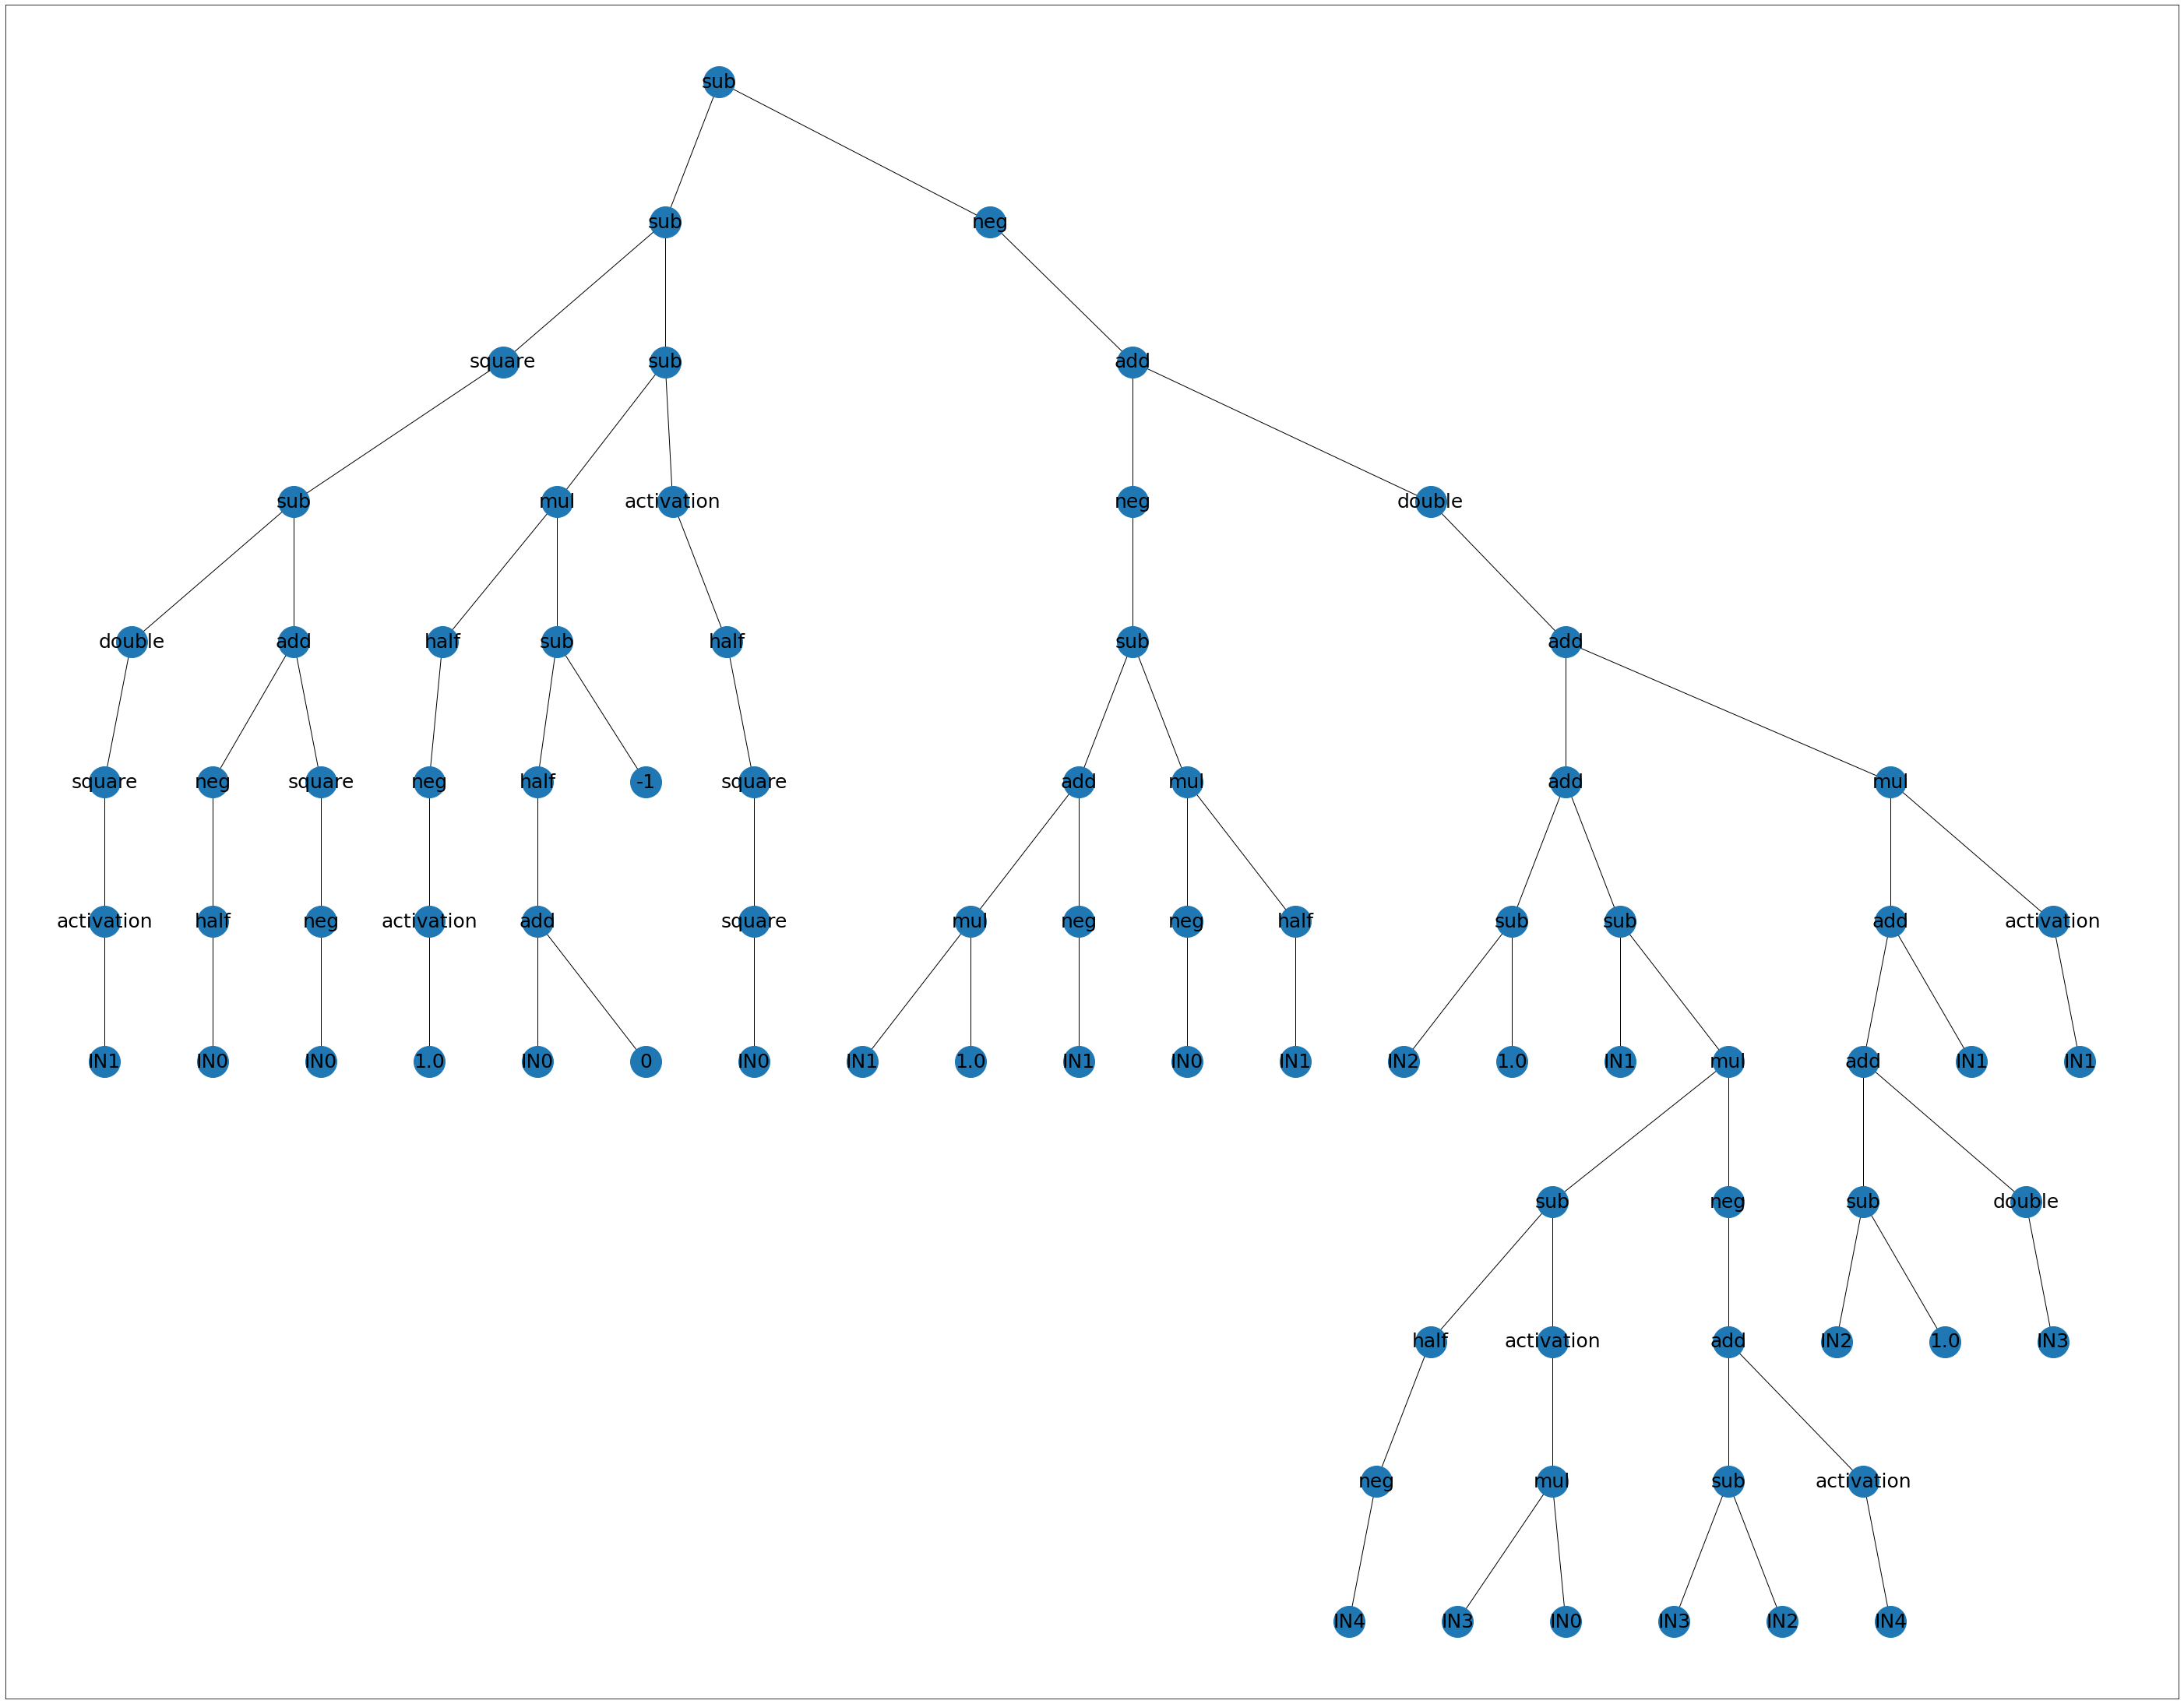

In [52]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

g = nx.Graph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)
pos = graphviz_layout(g, prog="dot")


nx.draw_networkx_nodes(g, pos, node_size=1600)
nx.draw_networkx_edges(g, pos)
nx.draw_networkx_labels(g, pos, labels, font_size=25)
plt.rcParams["figure.figsize"] = (50, 40)
plt.show()

analyze and display

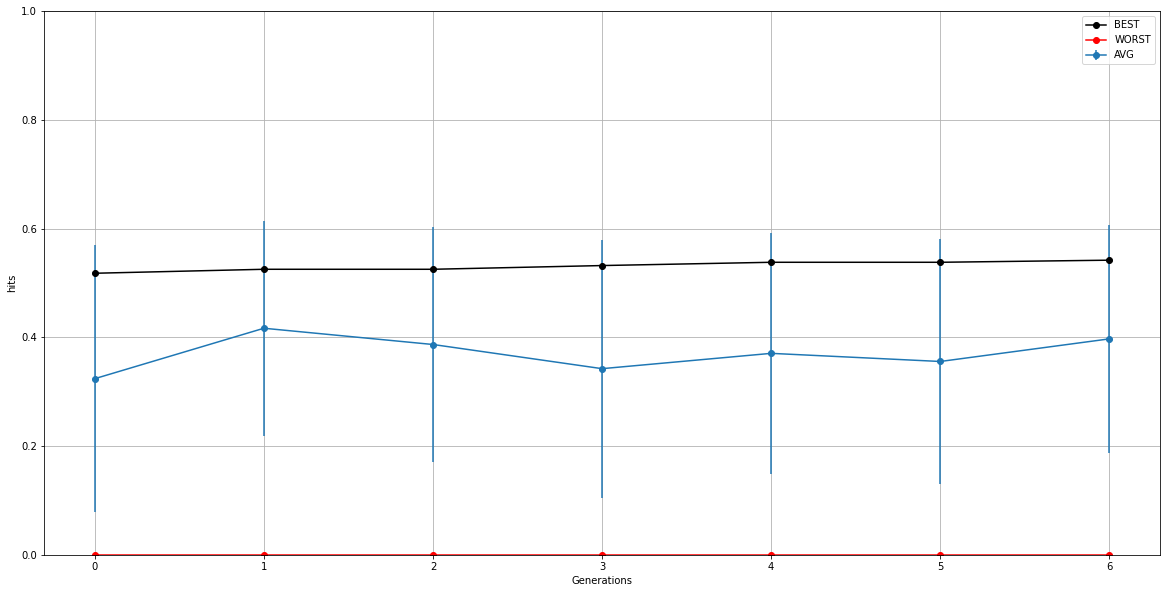

In [45]:
generations_idx = logbook.select('gen')
generations_avg = logbook.select('avg')
generations_std = logbook.select('std')
generations_max = logbook.select('max')
generations_min = logbook.select('min')

plt.figure(figsize=(20, 10))
plt.errorbar(generations_idx, generations_avg, yerr=generations_std, fmt='-o', label='AVG')
# plt.plot(generations_idx,generations_avg, '-o',label='AVG')
plt.plot(generations_max, '-o', label='BEST', color='black')
plt.plot(generations_min, '-o', label='WORST', color='red')
plt.grid()
plt.legend()
plt.xlabel('Generations')
plt.ylabel('hits')
plt.ylim(0, 1)
_ = plt.plot()

In [46]:
predictions = apply_function_to_df(winner_function).astype(np.int64)
true_results = datadf[labelcol]

scoring_sr = pd.DataFrame(dtype=np.float, columns=['value'])
scoring_sr.loc['Accuracy', 'value'] = accuracy_score(true_results, predictions)
scoring_sr.loc['Recall', 'value'] = recall_score(true_results, predictions)
scoring_sr.loc['precision', 'value'] = precision_score(true_results, predictions)
scoring_sr.loc['F0.25', 'value'] = fbeta_score(true_results, predictions, beta=0.25)

display(scoring_sr)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


,value
Accuracy,0.535231
Recall,0.226955
precision,0.593459
F0.25,0.541976
